In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import zoom
import zlib
import blosc

In [2]:
def Depth2Gray(d4d):
        d4d = 255 - cv2.cvtColor(d4d, cv2.COLOR_GRAY2RGB)
        return d4d

## Easy Intra-frame Compression Methods

### Test Compression Tools for Depth and Color Images

In [30]:
def depth_compress(i):
    name = "../pic/depth_"
    filename = name+str(i)+".png"
    depth = cv2.imread(filename)
    
    return len(depth.tostring()), len(zlib.compress(depth.tostring())), len(blosc.compress(depth.tostring(),cname="zlib"))
def color_compress(i):
    name = "../pic/rgb_"
    filename = name+str(i)+".png"
    color = cv2.imread(filename)
    return len(color.tostring()), len(zlib.compress(color.tostring())), len(blosc.compress(color.tostring(),cname="zlib"))

In [31]:
def lossless_sep(f):
    td=[]
    zd=[]
    bd=[]
    tc=[]
    zc=[]
    bc=[]
    tdv = zdv = bdv = tcv = zcv = bcv= 0
    for i in range(1, 441):
        t,z,b = depth_compress(i)
        td.append(t)
        zd.append(z)
        bd.append(b)
        t,z,b = color_compress(i)
        tc.append(t)
        zc.append(z)
        bc.append(b)
    tdv = np.sum(td)/440.0
    bdv = np.sum(bd)/440.0
    zdv = np.sum(zd)/440.0
    tcv = np.sum(tc)/440.0
    zcv = np.sum(zc)/440.0
    bcv = np.sum(bc)/440.0
    if (f):
        print("Depth:")
        print("Average Data size:",tdv)
        print("After Native Zlib Compression:",zdv , 
              "; Compression Rate:",zdv/tdv*100)
        print("After Blosc Compression:", bdv, 
              "; Compression Rate:",bdv/tdv*100)
        print("Color:")
        print("Average Data size: ", tcv)
        print("After Native Zlib Compression:",zcv , 
              "; Compression Rate:",zcv/tcv*100)
        print("After Blosc Compression:", bcv, 
              "; Compression Rate:",bcv/tcv*100)
    return td,zd,bd,tc,zc,bc

In [125]:
%timeit -r 1 -n 1 td,zd,bd,tc,zc,bc = lossless_sep(True)

Depth:
Average Data size: 921600.0
After Native Zlib Compression: 28160.7772727 ; Compression Rate: 3.05563989504
After Blosc Compression: 86453.2363636 ; Compression Rate: 9.38077651515
Color:
Average Data size:  921600.0
After Native Zlib Compression: 706109.188636 ; Compression Rate: 76.6177505031
After Blosc Compression: 824907.106818 ; Compression Rate: 89.5081496113
2min 29s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


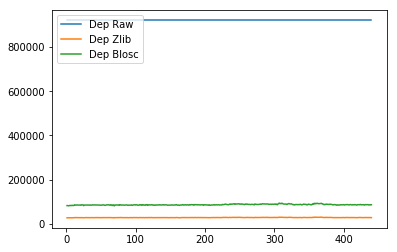

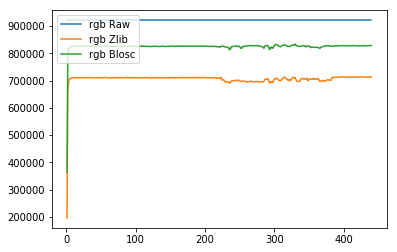

In [33]:
xaxis = np.arange(1,441)
plt.figure(1)
plt.plot(xaxis,td)
plt.plot(xaxis,zd)
plt.plot(xaxis,bd)
plt.legend(['Dep Raw', 'Dep Zlib', 'Dep Blosc'], loc='upper left')

plt.figure(2)
plt.plot(xaxis,tc)
plt.plot(xaxis,zc)
plt.plot(xaxis,bc)
plt.legend(['rgb Raw', 'rgb Zlib', 'rgb Blosc'], loc='upper left')
plt.show()

### Test the compression rate if transmit them together

In [37]:
def rgbd_compress(i):
    name = "../pic/depth_"
    filename = name+str(i)+".png"
    depth = cv2.imread(filename)
    name = "../pic/rgb_"
    filename = name+str(i)+".png"
    color = cv2.imread(filename)
    rgbd = np.dstack((color, depth))
    return len(rgbd.tostring()), len(zlib.compress(rgbd.tostring())), len(blosc.compress(rgbd.tostring()))

In [42]:
def lossless_rgbd(f):
    td=[]
    zd=[]
    bd = []
    tdv = bdv = zdv = 0
    for i in range(1, 441):
        t,z,b = rgbd_compress(i)
        td.append(t)
        zd.append(z)
        bd.append(b)
    tdv =np.sum(td)/440.0
    bdv =np.sum(bd)/440.0
    zdv =np.sum(zd)/440.0
    if(f):
        print("RGBD:")
        print("Average Date size：",tdv)
        print("After Native Zlib Compression:",zdv , 
              "; Compression Rate:",zdv/tdv*100)
        print("After Blosc Compression:", bdv, 
              "; Compression Rate:",bdv/tdv*100)
    return td,zd,bd

In [45]:
rtd,rzd,rbd = lossless_rgbd(True)

RGBD:
Average Date size： 1843200.0
After Native Zlib Compression: 903474.156818 ; Compression Rate: 49.0166100704
After Blosc Compression: 1553262.72727 ; Compression Rate: 84.2698962279


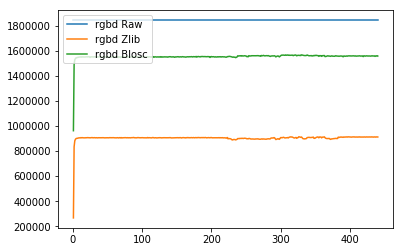

In [44]:
xaxis = np.arange(1,441)
plt.plot(xaxis,rtd)
plt.plot(xaxis,rzd)
plt.plot(xaxis,rbd)
plt.legend(['rgbd Raw', 'rgbd Zlib', 'rgbd Blosc'], loc='upper left')
plt.show()

### Lossy Intra-frame Compression - Zoom down and Zoom up

In [46]:
def depth_compress_lossy(i):
    name = "../pic/depth_"
    filename = name+str(i)+".png"
    depth = cv2.imread(filename)
    depth = zoom(depth, [0.5,0.5,1])
    n_depth = np.mean((zoom(depth, [2,2,1]) - cv2.imread(filename)))
    return len(depth.tostring()), len(zlib.compress(depth.tostring())), len(blosc.compress(depth.tostring())), n_depth
def color_compress_lossy(i):
    name = "../pic/rgb_"
    filename = name+str(i)+".png"
    color = cv2.imread(filename)
    color = zoom(color,[0.5,0.5,1])
    n_color = np.mean((zoom(color,[2,2,1]) - cv2.imread(filename)))
    return len(color.tostring()), len(zlib.compress(color.tostring())), len(blosc.compress(color.tostring())), n_color

In [109]:
def lossy_zoom(f):
    td_l=[]
    zd_l=[]
    bd_l=[]
    tc_l=[]
    zc_l=[]
    bc_l=[]
    nd = []
    nc = []
    for i in range(1, 441):
        t,z,b,n = depth_compress_lossy(i)
        td_l.append(t)
        zd_l.append(z)
        bd_l.append(b)
        nd.append(n)
        t,z,b,n = color_compress_lossy(i)
        tc_l.append(t)
        zc_l.append(z)
        bc_l.append(b)
        nc.append(n)
    if(f):
        print("Depth:")
        print("Average Date size：",np.mean(td_l))
        print("After Native Zlib Compression:",np.mean(zd_l) , 
              "; Compression Rate:",np.mean(zd_l)/np.mean(td_l)*100)
        print("After Blosc Compression:", np.mean(bd_l), 
              "; Compression Rate:",np.mean(bd_l)/np.mean(td_l)*100)
        print("Lossy rate: Ave of difference: ", np.mean(nd))
        print("Color:")
        print("Average Data size: ", np.mean(tc_l))
        print("After Native Zlib Compression:",np.mean(zc_l) , 
              "; Compression Rate:",np.mean(zc_l)/np.mean(tc_l)*100)
        print("After Blosc Compression:", np.mean(bc_l), 
              "; Compression Rate:",np.mean(bc_l)/np.mean(tc_l)*100)
        print("Lossy rate: Ave of difference: ", np.mean(nc))
    return td_l,zd_l, bd_l, tc_l, zc_l,  bc_l, nd , nc

In [110]:
td_l,zd_l, bd_l, tc_l, zc_l,  bc_l, nd , nc = lossy_zoom(True)

Depth:
Average Date size： 230400.0
After Native Zlib Compression: 24243.5204545 ; Compression Rate: 10.5223613084
After Blosc Compression: 93094.3159091 ; Compression Rate: 40.4055190578
Lossy rate: Ave of difference:  22.6231573079
Color:
Average Data size:  230400.0
After Native Zlib Compression: 197909.597727 ; Compression Rate: 85.8982629025
After Blosc Compression: 228345.743182 ; Compression Rate: 99.1083954782
Lossy rate: Ave of difference:  100.151102524


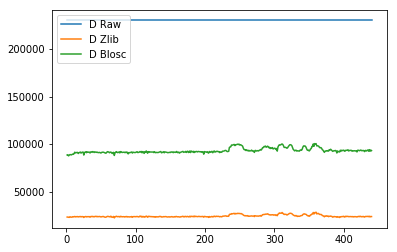

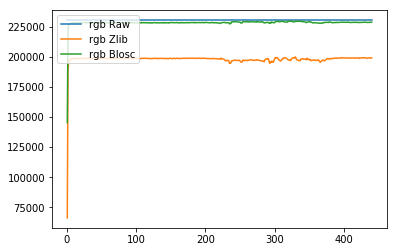

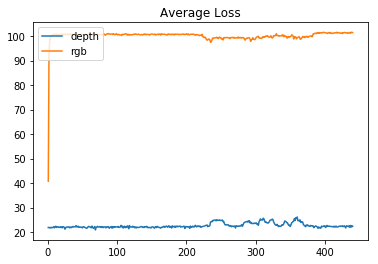

In [111]:
plt.figure(0)
xaxis = np.arange(1,441)
plt.plot(xaxis,td_l)
plt.plot(xaxis,zd_l)
plt.plot(xaxis,bd_l)
plt.legend(['D Raw', 'D Zlib', 'D Blosc'], loc='upper left')
plt.figure(1)
plt.plot(xaxis,tc_l)
plt.plot(xaxis,zc_l)
plt.plot(xaxis,bc_l)
plt.legend(['rgb Raw', 'rgb Zlib', 'rgb Blosc'], loc='upper left')
plt.figure(2)
plt.title("Average Loss")
plt.plot(xaxis,nd)
plt.plot(xaxis,nc)
plt.legend(['depth', 'rgb'], loc='upper left')
plt.show()

###  JPEG Intra-frame Compression (Lossy)

In [48]:
from PIL import Image
from io import BytesIO
from io import StringIO

In [126]:
def getData(i):
    name = "../pic/depth_"
    filename = name+str(i)+".png"
    depth = cv2.imread(filename)
    
    name = "../pic/rgb_"
    filename = name+str(i)+".png"
    color = cv2.imread(filename)
    return np.fromstring(depth, np.uint8).reshape(480,640,3), np.fromstring(color, np.uint8).reshape(480,640,3)

In [127]:
def testJPEG(qua, f):
    d=[]
    r=[]
    dd=[]
    rd=[]
    dv = rv = ddv= rdv =0
    for i in range(1,441):
        depth, rgb = getData(i)
        img = Image.fromarray(rgb)
        img1 = Image.fromarray(depth)
        fpath = BytesIO()
        img.save(fpath, quality = qua,optimize=True,format = "JPEG")
        fpath.seek(0)
        d.append((len(fpath.getvalue())))
        dpath = BytesIO()
        img1.save(dpath, quality = qua,optimize=True, format = "JPEG")
        dpath.seek(0)
        r.append((len(dpath.getvalue())))
        depth1 = np.array(Image.open(dpath))
        rgb1 = np.array(Image.open(fpath))
        rd.append(np.mean(rgb - rgb1))
        dd.append(np.mean(depth - depth1))
    dv = np.sum(d) / 440.0
    rv = np.sum(r) / 440.0
    rdv = np.sum(rd) / 440.0
    ddv = np.sum(dd) / 440.0
    if(f):
        print("Depth:"+str(qua))
        print("Average After compressed:"+str(dv))
        print("Compression rate: "+str(dv/307200.0*100)+"%")
        print("Average Loss : "+str(ddv))
        print("Color:"+str(qua))
        print("Average After compressed:"+str(rv))
        print("Compression rate: "+str(rv/307200.0*100)+"%")
        print("Average Loss : "+str(rdv))
    return dv,rv,ddv,rdv

In [128]:
def JPEG(f):
    dvl = []
    rvl = []
    ddvl = []
    rdvl = []
    for i in range(95, 50, -5):
        dv,rv,ddv,rdv = testJPEG(i, f)
        dvl.append(dv)
        rvl.append(rv)
        ddvl.append(ddv)
        rdvl.append(rdv)

In [129]:
%timeit -r 1 -n 1 JPEG(False)

3min 48s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


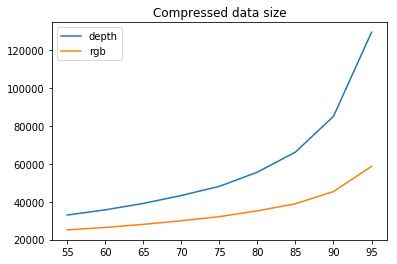

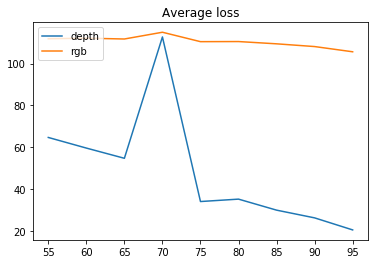

In [130]:
xaxie = range(95,50,-5)
plt.figure(4)
plt.plot(xaxie,dvl)
plt.plot(xaxie,rvl)
plt.legend(['depth', 'rgb'], loc='upper left')
plt.title("Compressed data size")
plt.figure(5)
plt.plot(xaxie,ddvl)
plt.plot(xaxie,rdvl)
plt.legend(['depth', 'rgb'], loc='upper left')
plt.title("Average loss")
plt.show() 

### Compare Compression Rate

In [131]:
#lossless compression
#Depth
depth_rate_zlib = np.mean(np.multiply(np.divide(zd,td),100))
depth_rate_blosc = np.mean(np.multiply(np.divide(bd,td),100))

#rgb
rgb_rate_zlib = np.mean(np.multiply(np.divide(zc,tc),100))
rgb_rate_blosc = np.mean(np.multiply(np.divide(bc,tc),100))

#rgbd 
rgbd_rate_zlib = np.mean(np.multiply(np.divide(rzd,rtd),100))
rgbd_rate_blosc = np.mean(np.multiply(np.divide(rbd,rtd),100))

#Lossy Compression
depth_lossy = np.mean(np.multiply(np.divide(dvl[4],307200.0),100))
rgb_lossy = np.mean(np.multiply(np.divide(rvl[4],307200.0),100))

depth_zoom_lossy_zlib = np.mean(np.multiply(np.divide(zd_l,td_l),100))
rgb_zoom_lossy_zlib = np.mean(np.multiply(np.divide(zc_l,tc_l),100))


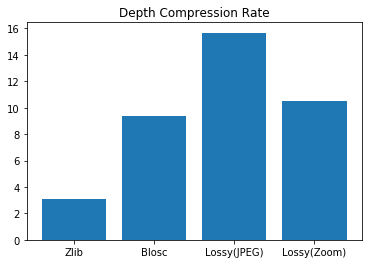

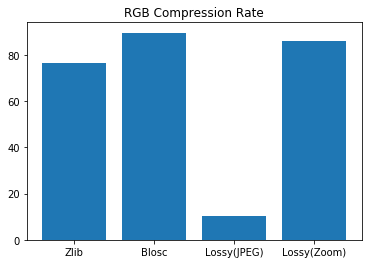

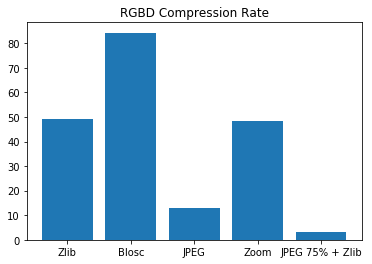

In [132]:
#Depth Compression
plt.figure(1)
xnames = ("Zlib", "Blosc", "Lossy(JPEG)", "Lossy(Zoom)")
x_pos = range(len(xnames))
plt.bar(x_pos,[depth_rate_zlib,depth_rate_blosc,depth_lossy, depth_zoom_lossy_zlib])
plt.xticks(x_pos, xnames)
plt.title("Depth Compression Rate")

#rgb Compression
plt.figure(2)
xnames = ("Zlib", "Blosc", "Lossy(JPEG)","Lossy(Zoom)")
x_pos = range(len(xnames))
plt.bar(x_pos,[rgb_rate_zlib,rgb_rate_blosc,rgb_lossy, rgb_zoom_lossy_zlib])
plt.xticks(x_pos, xnames)
plt.title("RGB Compression Rate")


#rgbd compression (Quality 75%)
plt.figure(3)
rgbd_lossy = np.mean(np.append(np.multiply(np.divide(dvl[4],307200.0),100),np.multiply(np.divide(rvl[4],307200.0),100)))
rgbd_lossy_2 = np.mean(np.append(np.multiply(np.divide(zd,td),100),np.multiply(np.divide(rvl[4],307200.0),100)))
rgbd_lossy_1 = np.mean(np.append(np.multiply(np.divide(zd_l,td_l),100),np.multiply(np.divide(zc_l,tc_l),100)))

#rgb Compression
xnames = ("Zlib", "Blosc", "JPEG","Zoom","JPEG 75% + Zlib")
x_pos = range(len(xnames))
plt.bar(x_pos,[rgbd_rate_zlib,rgbd_rate_blosc,rgbd_lossy, rgbd_lossy_1, rgbd_lossy_2])
plt.xticks(x_pos, xnames)
plt.title("RGBD Compression Rate")
plt.show()